In [1]:
from dotenv import load_dotenv
from langchain_core.messages import HumanMessage,AIMessage,BaseMessage,SystemMessage,ToolMessage
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
import os
from lean_interact import LeanREPLConfig, AutoLeanServer, Command,LocalProject
from lean_interact.interface import CommandResponse
import nest_asyncio
from git import Repo
from typing import Optional, TypedDict
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import Annotated,Sequence,TypedDict,List
from langchain_community.chat_models import ChatTongyi
from utils import *
from typing import TypedDict, Union
import uuid


nest_asyncio.apply()
load_dotenv()

[08:53:25] INFO     For optimal use on Windows, enable long paths by running this command as           ]8;id=608771;file://d:\git_clone\LEL\.pixi\envs\default\Lib\site-packages\lean_interact\utils.py\utils.py]8;;\:]8;id=750634;file://d:\git_clone\LEL\.pixi\envs\default\Lib\site-packages\lean_interact\utils.py#117\117]8;;\
                    administrator:                                                                                 

           INFO     New-ItemProperty -Path "HKLM:\SYSTEM\CurrentControlSet\Control\FileSystem" -Name   ]8;id=744170;file://d:\git_clone\LEL\.pixi\envs\default\Lib\site-packages\lean_interact\utils.py\utils.py]8;;\:]8;id=787982;file://d:\git_clone\LEL\.pixi\envs\default\Lib\site-packages\lean_interact\utils.py#118\118]8;;\
                    LongPathsEnabled -Value 1 -PropertyType DWord -Force                                           

           INFO     For optimal use on Windows, configure git for long paths by running:               ]8;id=248577;file://d:\git_clone\LEL\.pixi\envs\default\Lib\site-packages\lean_interact\utils.py\utils.py]8;;\:]8;id=205114;file://d:\git_clone\LEL\.pixi\envs\default\Lib\site-packages\lean_interact\utils.py#136\136]8;;\

           INFO     git config --global core.longpaths true                                            ]8;id=107665;file://d:\git_clone\LEL\.pixi\envs\default\Lib\site-packages\lean_interact\utils.py\utils.py]8;;\:]8;id=572729;file://d:\git_clone\LEL\.pixi\envs\default\Lib\site-packages\lean_interact\utils.py#137\137]8;;\

API Client initialized.


True

In [ ]:
vec_store=VectorStore(r".\src\src_md",r".\src\src_VectorStore")
retriever_tool=vec_store.retriever_tool
#vec_store.sync_md(r".\src\src_pdf")

local_repo_path = "./mathlib4"
if not os.path.exists(local_repo_path):
    print(f"本地路径 {local_repo_path} 不存在，开始克隆 GitHub 仓库...")
    try:
        # 使用 ! 执行系统命令克隆仓库
        github_repo_url="https://github.com/leanprover-community/mathlib4.git"
        Repo.clone_from(github_repo_url, local_repo_path)
        print(f"GitHub 仓库 {github_repo_url} 已成功克隆到 {local_repo_path}")
    except Exception as e:
        print(f"克隆仓库时出错: {e}")
else:
    print(f"本地路径 {local_repo_path} 已存在，跳过克隆操作。")

config = LeanREPLConfig(project=LocalProject(directory=local_repo_path))
server = AutoLeanServer(config)
print(server.run(Command(cmd="theorem ex (n : Nat) : n = 5 → n = 5 := id")))

sync_store 完成
本地路径 ./mathlib4 已存在，跳过克隆操作。
CommandResponse(env=0)


In [ ]:
# llm=ChatGoogleGenerativeAI(
#     model="gemini-2.5-flash",
#     temperature=0,
#     max_tokens=None,
#     timeout=None,
# )    

llm=ChatTongyi(model="qwen-max",temperature=0.0,max_tokens=None,timeout=None)
prover=Prover(model_ls=["hf.co/DevQuasar/AI-MO.Kimina-Prover-Preview-Distill-7B-GGUF:Q4_K_M"],plantform="local")

In [4]:
class AgentState(TypedDict):
    initMessages: Annotated[Sequence[BaseMessage], add_messages]
    proverMessages : dict[str,BaseMessage]
    agentMessages : Annotated[Sequence[BaseMessage], add_messages]
    
class LeanState(TypedDict):
    query : str | None 
    background : str | None 
    leanQuery : str | None
    leanTheorem : str | None

class Tree(TypedDict):
    leaves : dict[str , list[Union[str,CommandResponse]]]

In [5]:
print(llm.invoke("HI"))
print(prover.ainvoke(r"use lean to prove 2 is not in \mathbb{Q}"))

content='Hello! How can I assist you today?' additional_kwargs={} response_metadata={'model_name': 'qwen-max', 'finish_reason': 'stop', 'request_id': '4a44d722-10e7-9dac-9ce6-ec30ae54b0ec', 'token_usage': {'input_tokens': 9, 'output_tokens': 9, 'total_tokens': 18, 'prompt_tokens_details': {'cached_tokens': 0}}} id='run--6840048f-b762-4b0e-9211-a5b6ab09d3f4-0'
run prover
{'hf.co/DevQuasar/AI-MO.Kimina-Prover-Preview-Distill-7B-GGUF:Q4_K_M_0': AIMessage(content="# Informal Proof:\nThis is a proof by contradiction. Assume that $2 \\in \\mathbb{Q}$. This means that there exists a fraction $\\frac{p}{q}$, where $p$ and $q$ are integers with no common factors (i.e., the fraction is in its simplest form), such that $\\frac{p}{q} = 2$.\n\nSquaring both sides of the equation gives us $\\left(\\frac{p}{q}\\right)^2 = 2^2$, which simplifies to $\\frac{p^2}{q^2} = 4$. This leads to $p^2 = 4q^2$.\n\nThis implies that $p^2$ is a multiple of 4, and therefore $p$ must also be a multiple of 2 (since th

In [6]:
leanState:LeanState={}
tree:Tree={"leaves":{}}

@tool
def updateLeanState(stateName,text:str):
    """
    更新AgentState
    Args:
        stateName:leanState 其中元素的名称
        text:需要写入的内容
    """
    global leanState
    leanState[stateName]=text
    return f"leanState更新完成，更新了{stateName}"

@tool
def update_leaf_message(lean:str):
    """
    向树形结构添加新的解释信息
    
    参数:
        lean: 待解释的文本内容
    
    返回:
        包含操作结果的状态信息
    功能:
        1. 生成唯一标识符作为新节点ID
        2. 创建包含原始文本和解释结果的元组
        3. 将元组添加到树结构的leaves字典中
        4. 返回更新后的树结构信息
    
    依赖:
        - server.run(): 执行命令并返回lean解释器结果
        - uuid.uuid4(): 生成随机唯一标识符的函数
        - tree: 全局变量，存储树形结构的字典
    """
    global tree
    random_id=str(uuid.uuid4())
    tree['leaves'][random_id]=[lean,server.run(Command(cmd=lean))]
    print("节点更新")
    return f"leanMessages 已更新了节点 {random_id}"

@tool
def delete_leaf_message(leaf_id: str) -> dict:
    """
    从树结构中删除指定ID的叶子节点
    
    Args:
        leaf_id: 要删除的叶子节点ID
        
    Returns:
        包含操作结果的字典
    """
    global tree
    if leaf_id not in tree["leaves"]:
        return  f"error : 叶子节点ID '{leaf_id}'不存在"
        
    tree["leaves"].pop(leaf_id)
    print("节点删除")
    return f"叶子节点ID '{leaf_id}'已成功删除"

@tool
def save(filename: str, lean: str) -> str:
    """将lean证明保存为Lean格式的文本文件并结束流程。
    
    参数:
        filename: 文本文件名称。
        lean: 要保存的Lean代码内容。
    """

    # 确保文件名以.lean扩展名结尾
    if not filename.endswith('.lean'):
        filename = f"{filename}.lean"

    try:
        with open(filename, 'w', encoding='utf-8') as file:
            file.write(lean)
        print(f"文档已保存至: {filename}")
        return f"文档已成功保存至 '{filename}'。"
    
    except Exception as e:
        return f"保存文档时出错: {str(e)}"

In [7]:
systemPrompt={
    "init":"""
    你的任务：
        1.你需要将leanState.query中的内容转换为lean语言，记录在leanState.leanQuery中,或者将leanState.leanQuery中的内容转换为自然语言，记录在leanState.qurey中，在这里，你并不需要解答问题，只需翻译即可。
        2.你需要搜一些背景知识，为了帮助在你之后的模型理解，你需要将你搜集到的知识存储到leanState.background中。
        3.你需要搜索一些关于该题目中使用的lean theorem，你需要将你搜到的知识存储到leanState.leanTheorem中。
    你可以调用的工具：
        1.updateLeanState 用来更新leanState
        2.search_lean_theorem 用来搜索lean theorem的内容
        3.ddgs_search 用来搜索网络中的内容
        4.retriever_tool 用来搜索知识库中的信息
    leanState的结构：
        class LeanState(TypedDict):
            query : str | None 
            background : str | None 
            leanQuery : str | None
            leanTheorem : str | None
    """,
    "prover":f"""
    你的任务：
        1.你需要根据leanState信息的协助下写出证明
            其中 query是问题的自然语言表达
                 backgroud是关于问题的一些背景知识
                 leanQuery是问题的lean语言陈述
                 leanTheorem是问题可能使用到的定理
        2.你可能会参考到以前给出的证明（不一定正确）
            结构即{{"leaves": {{"leaf_id":["lean_proof","leanInterpreted"]}}}}
    """,
    "agent":f"""
    你的任务：
        1.总结proverMessages中的信息，记录在tree中，并且随时更新或删除tree中的内容（使用工具delete_leaf_message或update_leaf_message），你需要保证，百分之五十的证明淘汰率。
        2.当你觉得tree中的证明令你满意，你可以使用工具save来保存该证明（证明包括：lean证明和注释的自然语言证明），这样可以退出程序，完成证明。
        3.当你发现了某个证明引用了不存在的定理，你可以使用search_lean_theorem，你需要将你搜到的知识存储到leanState.leanTheorem中。
    你可以调用的工具：
        1.search_lean_theorem：搜索lean定理
        2.delete_leaf_message：删除tree中某个证明
        3.update_leaf_message：更新证明
        4.updateLeanState：更新leanState
        5.save：保存lean的证明
    tree的结构:
        class Tree(TypedDict):
            leaves : dict[str , list[Union[str,CommandResponse]]]
            结构即 {{"leaves": {{"leaf_id":["lean_proof","leanInterpreted"]}}}}
    leanState的结构：
        class LeanState(TypedDict):
            query : str | None 
            background : str | None 
            leanQuery : str | None
            leanTheorem : str | None
    """
}

init_tools=[updateLeanState,search_lean_theorem,ddgs_search,retriever_tool]
agent_tools=[search_lean_theorem,updateLeanState,save,delete_leaf_message,update_leaf_message]
init_llm=llm.bind_tools(init_tools)
agent_llm=llm.bind_tools(agent_tools)
def call_init_llm(state:AgentState)-> AgentState:
    system=SystemMessage(content=systemPrompt["init"])
    response=init_llm.invoke([system]+state["initMessages"])
    return {"initMessages":[response]}

def call_prover_llm(state:AgentState) -> AgentState:
    prompt = f"tree :{tree},leanState:{leanState}"
    system = systemPrompt["prover"] + prompt
    prover_results =prover.ainvoke(system)
    state["proverMessages"] = prover_results
    return state

def cal_agent_llm(state:AgentState)->AgentState:
    historymess = state.get("agentMessages", [])
    provermess=state["proverMessages"]
    prompt=f"tree:{tree},leanState:{leanState},proverMessages:{provermess}"
    system=SystemMessage(content=systemPrompt["agent"]+prompt)
    response=agent_llm.invoke([system]+historymess)
    print(response)
    return {"agentMessages":[response]}

def should_init_continue(state :AgentState):
    """check the last massage contants tool call"""
    result=state["initMessages"][-1]
    return hasattr(result,"tool_calls") and len(result.tool_calls) > 0

def should_agent_continue(state: AgentState) -> str:
    """Determine if we should continue or end the conversation."""

    messages = state["agentMessages"]
    
    if not messages:
        return "continue"
    
    # This looks for the most recent tool message....
    for message in reversed(messages):
        if (isinstance(message, ToolMessage) and 
            message.name=="save"):
            return "end" 
    return "continue"

def should_agent_prover(state:AgentState):
    result=state["agentMessages"][-1]
    return hasattr(result,"tool_calls") and len(result.tool_calls) > 0

In [8]:
graph=StateGraph(AgentState)

init_tool_node=ToolNode(init_tools,messages_key="initMessages")
agent_tool_node=ToolNode(agent_tools,messages_key="agentMessages")

graph.add_node("init_node",call_init_llm)
graph.add_node("init_tool_node",init_tool_node)
graph.add_node("prover_node",call_prover_llm)
graph.add_node("agent_node",cal_agent_llm)
graph.add_node("agent_tool_node",agent_tool_node)

graph.add_edge(START,"init_node")
graph.add_edge("init_tool_node","init_node")
graph.add_edge("prover_node","agent_node")

graph.add_conditional_edges("init_node",should_init_continue,{True:"init_tool_node",False:"prover_node"})
graph.add_conditional_edges("agent_tool_node",should_agent_continue,{"continue":"agent_node","end":END})
graph.add_conditional_edges("agent_node",should_agent_prover,{True:"agent_tool_node",False:"prover_node"})
agent=graph.compile()

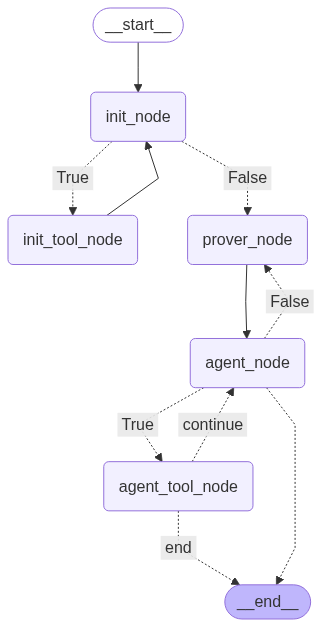

In [9]:
from IPython.display import display, Image

display(Image(agent.get_graph().draw_mermaid_png()))

In [12]:
res=await agent.ainvoke({"initMessages":[HumanMessage(content="为什么根号二不是有理数？")]},config = {"recursion_limit": 100})

run prover
content='' additional_kwargs={'tool_calls': [{'function': {'name': 'update_leaf_message', 'arguments': '{"lean": "import Mathlib\\n\\ntheorem irrational_sqrt_two : Irrational (√2) := by \\n  native_decide"}'}, 'index': 0, 'id': 'call_c077edbc9931402897dbf8', 'type': 'function'}]} response_metadata={'model_name': 'qwen-max', 'finish_reason': 'tool_calls', 'request_id': '9ff7e884-6203-9ae0-968b-d0c013043d3c', 'token_usage': {'input_tokens': 2778, 'output_tokens': 38, 'total_tokens': 2816, 'prompt_tokens_details': {'cached_tokens': 0}}} id='run--29a353c4-346e-4195-9078-0ea24a18215f-0' tool_calls=[{'name': 'update_leaf_message', 'args': {'lean': 'import Mathlib\n\ntheorem irrational_sqrt_two : Irrational (√2) := by \n  native_decide'}, 'id': 'call_c077edbc9931402897dbf8', 'type': 'tool_call'}]
节点更新
content='' additional_kwargs={'tool_calls': [{'function': {'name': 'delete_leaf_message', 'arguments': '{"leaf_id": "12d6e0dd-7cb5-48aa-8140-63eda9d2258f"}'}, 'index': 0, 'id': 'call_

In [13]:
res

{'initMessages': [HumanMessage(content='为什么根号二不是有理数？', additional_kwargs={}, response_metadata={}, id='34e5a7da-b330-4f15-81f9-742ebeec1beb'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'function': {'name': 'updateLeanState', 'arguments': '{"stateName": "query", "text": "为什么根号二不是有理数？"}'}, 'index': 0, 'id': 'call_797a2ae84f5842299f8916', 'type': 'function'}]}, response_metadata={'model_name': 'qwen-max', 'finish_reason': 'tool_calls', 'request_id': '87b1888d-606e-9959-a4fa-48ee09d78476', 'token_usage': {'input_tokens': 812, 'output_tokens': 30, 'total_tokens': 842, 'prompt_tokens_details': {'cached_tokens': 0}}}, id='run--0a036b1f-a7f6-404a-af21-6a1398a28947-0', tool_calls=[{'name': 'updateLeanState', 'args': {'stateName': 'query', 'text': '为什么根号二不是有理数？'}, 'id': 'call_797a2ae84f5842299f8916', 'type': 'tool_call'}]),
  ToolMessage(content='leanState更新完成，更新了query', name='updateLeanState', id='2f370e24-d326-4842-a475-15165890b406', tool_call_id='call_797a2ae84f5842299f8916'

In [ ]:
leanState

{'query': '为什么根号二不是有理数？',
 'leanQuery': 'sqrt(2) ∉ ℚ',
 'background': '根号二，即√2，是最早被发现的无理数之一。相传毕达哥拉斯学派的希帕索斯首次提出了“√2不是有理数”的命题。在数学中，有理数是指可以表示为两个整数比（分数形式）的数，而无理数则是不能够精确地表示为任何两个整数比例的实数。证明√2是无理数的方法通常是采用反证法：假设√2是有理数，并由此导出矛盾，从而证明了√2实际上是无理数。',
 'leanTheorem': '在Lean中，存在一个定理`irrational_sqrt_two`表明根号二是无理数。该定理的形式化表述为：\n\n```lean\ntheorem irrational_sqrt_two : Irrational (√2)\n```\n\n这表示√2是一个无理数。'}

In [15]:
tree

{'leaves': {'d442200d-2d1b-4851-bcf3-f5d18abbf6e4': ['import Mathlib\n\ntheorem irrational_sqrt_two : Irrational (√2) := by \n  apply irrational_sqrt_two',
   CommandResponse(env=2, messages=[Message(end_pos=Pos(line=3, column=27), severity='error', data="'irrational_sqrt_two' has already been declared", start_pos=Pos(line=3, column=8))])]}}

In [ ]:
server.run(Command(cmd="""import Mathlib

example : Irrational (√2) := by 
  apply irrational_sqrt_two"""))


CommandResponse(env=1)

## lean
1. 交互性
2. 从lean模型到自然语言模型
